# Anticipez les besoins en consommation de bâtiments

# Analyse exploratoire

## Mission

Vous travaillez pour la **ville de Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des **bâtiments non destinés à l’habitation**.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments **non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

*Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)*

Vous cherchez également à **évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions**, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

**Douglas** : *L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..*

*Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).*

*Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.*

Import des librairies utilisées

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
sns.set_theme(style='whitegrid', palette='pastel')

Import du dataset récupéré sur le site de la ville de Seattle, mis à jour le 21/04/2023.

In [2]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

# Nettoyage des données

Je travaille sur une copie du dataframe d'origine.

In [3]:
df = data.copy()

In [4]:
# Structure du dataframe
df.shape

(3376, 46)

In [5]:
# Visualisation de toutes les colonnes
pd.set_option('display.max_column', 46)
df.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.6122,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.5,189.0,7226362.5,7456910.0,2003882.0,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


Avant de d'aller plus loin, il faut me concentrer sur les immeubles non concernés par l'habitat résidentiel.
C'est la variable *BuildingType* qui va permettre un filtre.

In [6]:
df['BuildingType'].unique().tolist()

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

Je dois éliminer toutes les observations contenant *family*.

In [7]:
df = df.loc[~df['BuildingType'].str.contains('family')]

In [8]:
df.shape

(1668, 46)

In [9]:
# Type de données dans les colonnes
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

In [10]:
# Recherche d'éventuelles observations dupliquées
df.duplicated().sum()

0

## Observation des variables - Colonnes inutiles
Liste des colonnes

In [11]:
df.columns.tolist()

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

<Axes: >

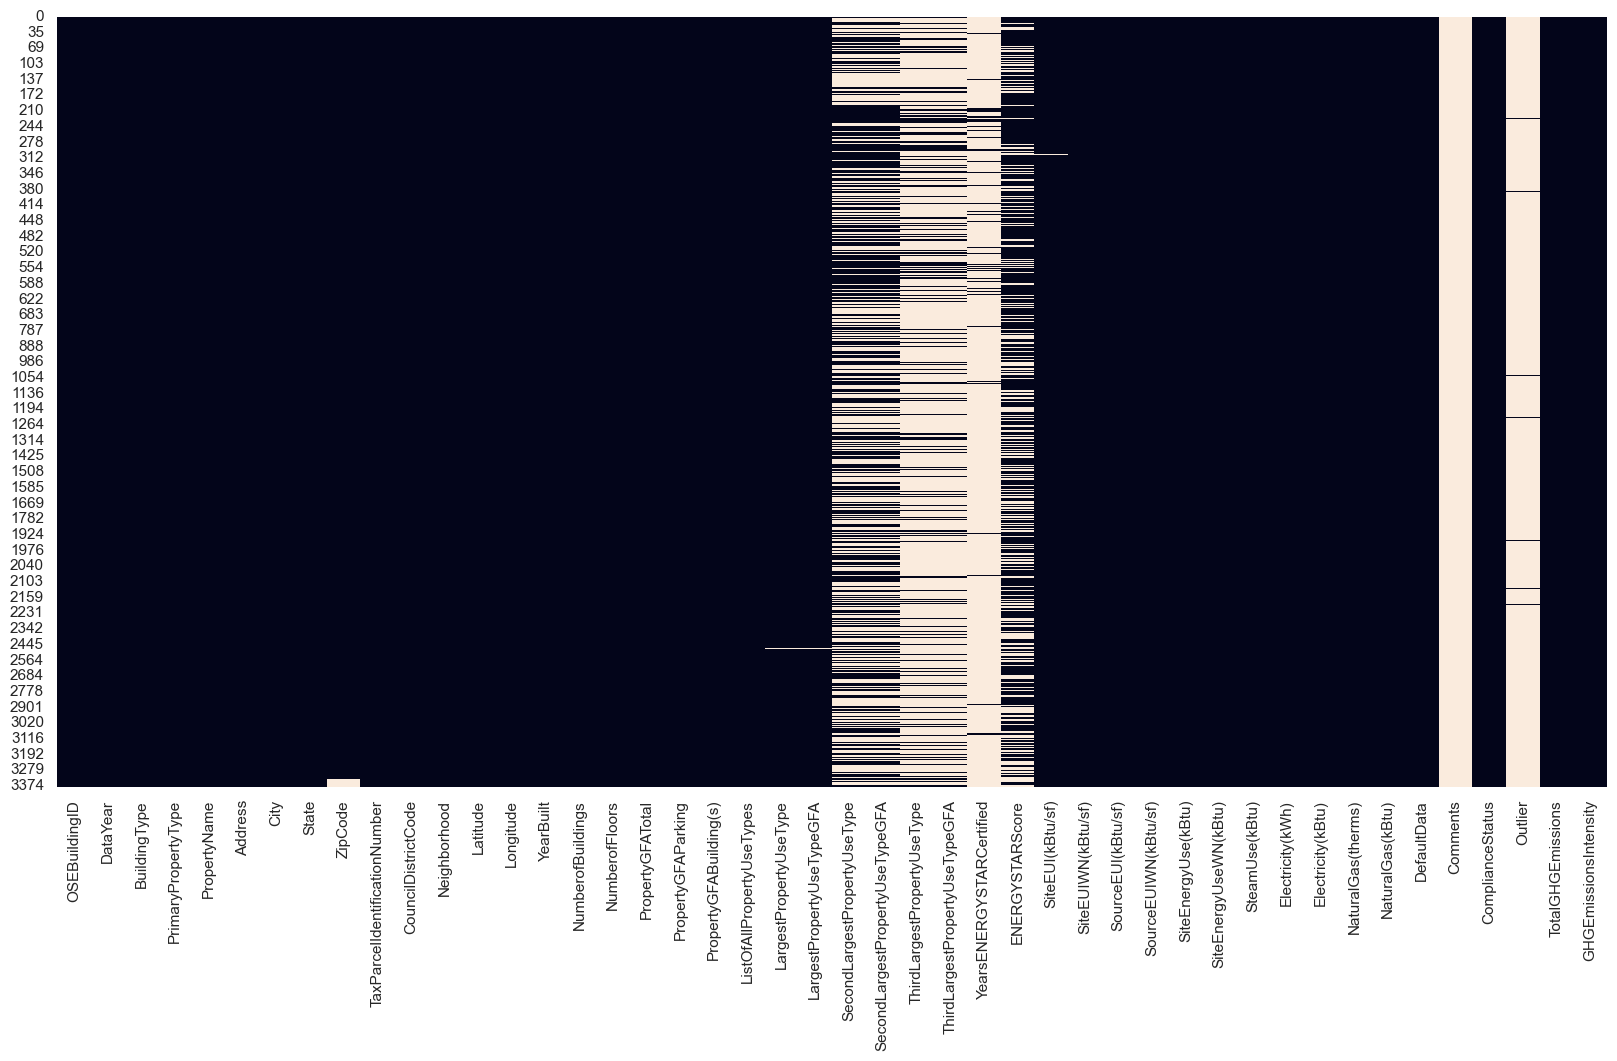

In [12]:
# Où sont les données manquantes ?

plt.figure(figsize=(20, 10))
sns.heatmap(df.isna(), cbar=False)

In [13]:
#Quel est le taux de manquants global ?

df.isna().mean().mean()

0.12746324679386928

J'utilise une fonction pour quantifier les manquants :

In [14]:
def calcul_remplissage(dataframe):
    
    dictionnaire = {}

    for colonne in dataframe.columns:
        dictionnaire[colonne] = []
        dictionnaire[colonne].append(round((1 - dataframe[colonne].isna().mean())*100, 1))
        dictionnaire[colonne].append(dataframe[colonne].isna().sum())

    return pd.DataFrame.from_dict(data=dictionnaire, orient='index', columns = ['Taux de remplissage', 'Nombre de manquants']).sort_values(by='Taux de remplissage', ascending=False)

In [15]:
calcul_remplissage(df)

,Taux de remplissage,Nombre de manquants
OSEBuildingID,100.0,0
Neighborhood,100.0,0
DataYear,100.0,0
DefaultData,100.0,0
PropertyGFABuilding(s),100.0,0
PropertyGFAParking,100.0,0
PropertyGFATotal,100.0,0
NumberofFloors,100.0,0
ComplianceStatus,100.0,0
Longitude,100.0,0


## Choix des variables
Le dataframe est globalement bien rempli.

Les variables appartiennent à différentes catégories :
- identification
- usages
- caractéristiques constructives
- localisation
- consommations énergétiques
- émissions de gaz à effet de serre

Les 2 targets sont choisies :
- **SiteEnergyUseWN(kBtu)** pour les consommations d'énergie
- **TotalGHGEmissions** pour les émissions de gaz à effet de serre

Les consommations par unité de surface sont données à la fois en net et en brut (incluant les pertes en ligne de la production, transmission et distribution). La consommation brute ne sera pas retenue car ce principe est moins utilisé dans le dataframe.

Les unités énergétiques sont diverses. Pour un souci de comparaison juste, ne seront retenues que les variables en kBtu, la plus utilisée ici.

Je conserve momentanément la variable *Outlier* car elle est explicite et permettra d'éliminer directement des observations considérées comme anormales.

In [16]:
variables = [
 'SiteEnergyUseWN(kBtu)',
 'TotalGHGEmissions',
 'BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUIWN(kBtu/sf)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'Outlier',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)']
df = df[variables]
df.head(1)

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity,SiteEnergyUse(kBtu)
0,7456910.0,249.98,NonResidential,Hotel,DOWNTOWN,47.6122,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,84.300003,2003882.0,3946027.0,1276453.0,NaN,2.83,7226362.5


Je traite la variable *Outlier* en éliminant les observations identifiées comme telles.

Je supprime la colonne dans la foulée.

In [17]:
df = df.loc[df['Outlier'].isna()]
df.drop(columns='Outlier', inplace = True)
df.head(1)

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,SiteEnergyUse(kBtu)
0,7456910.0,249.98,NonResidential,Hotel,DOWNTOWN,47.6122,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,84.300003,2003882.0,3946027.0,1276453.0,2.83,7226362.5


Je recherche les observations incohérentes où la somme des surfaces des différents usages est supérieure à la surface totale :

In [18]:
df = df.loc[~(df['PropertyGFATotal'] < (df['LargestPropertyUseTypeGFA'] + df['SecondLargestPropertyUseTypeGFA'] + df['ThirdLargestPropertyUseTypeGFA']))]

Je recherche aussi à éliminer les observations pour lesquelles la somme des consommations d'énergies dépasse la consommation totale.
J'utilise la consommation totale non normalisée avec la météo pour être cohérent avec les autres unités.

In [19]:
df = df.loc[~(df['SiteEnergyUse(kBtu)'] < (df['SteamUse(kBtu)'] + df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']))]
df

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,SiteEnergyUse(kBtu)
0,7.456910e+06,249.98,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,84.300003,2003882.00,3.946027e+06,1.276453e+06,2.83,7.226362e+06
1,8.664479e+06,295.86,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,0.00,3.242851e+06,5.145082e+06,2.86,8.387933e+06
2,7.393711e+07,2089.28,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,97.699997,21566554.00,4.952666e+07,1.493800e+06,2.19,7.258702e+07
3,6.946800e+06,286.43,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,113.300003,2214446.25,2.768924e+06,1.811213e+06,4.67,6.794584e+06
5,1.258171e+07,301.81,Nonresidential COS,Other,DOWNTOWN,47.61623,-122.33657,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,141.600006,0.00,7.371434e+06,4.715182e+06,3.10,1.208662e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1.025432e+06,20.33,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1982,1.0,1,18261,0,18261,Other - Recreation,Other - Recreation,18261.0,NaN,NaN,NaN,NaN,NaN,56.200001,0.00,6.323620e+05,2.997200e+05,1.11,9.320821e+05
3372,1.053706e+06,32.17,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,65.900002,0.00,3.965461e+05,5.537300e+05,2.01,9.502762e+05
3373,6.053764e+06,223.54,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,460.100006,0.00,1.792159e+06,3.973739e+06,16.99,5.765898e+06
3374,7.828413e+05,22.11,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,55.500000,0.00,3.488702e+05,3.706010e+05,1.57,7.194712e+05


Où en sont les taux de remplissage ?

In [20]:
calcul_remplissage(df)

,Taux de remplissage,Nombre de manquants
BuildingType,100.0,0
PrimaryPropertyType,100.0,0
Neighborhood,100.0,0
Latitude,100.0,0
Longitude,100.0,0
YearBuilt,100.0,0
NumberofFloors,100.0,0
PropertyGFATotal,100.0,0
PropertyGFAParking,100.0,0
PropertyGFABuilding(s),100.0,0


Je ne touche pas à l'*ENERGYSTARScore* mais je transforme les **NaN** des usages second et tiers des immeubles (ils n'ont qu'un seul usage principal) en une modalité **Aucun** et de surface **0**.

In [21]:
df.loc[df['SecondLargestPropertyUseType'].isna(), 'SecondLargestPropertyUseType'] = 'Aucun'
df.loc[df['SecondLargestPropertyUseTypeGFA'].isna(), 'SecondLargestPropertyUseTypeGFA'] = 0
df.loc[df['ThirdLargestPropertyUseType'].isna(), 'ThirdLargestPropertyUseType'] = 'Aucun'
df.loc[df['ThirdLargestPropertyUseTypeGFA'].isna(), 'ThirdLargestPropertyUseTypeGFA'] = 0

Pour les autres variables, je supprime les dernières observations contenant encore des manquants :

In [22]:
df = df.loc[(df['SiteEnergyUseWN(kBtu)'].notna()) & 
            (df['TotalGHGEmissions'].notna()) & 
            (df['LargestPropertyUseType'].notna()) & 
            (df['LargestPropertyUseTypeGFA'].notna())]

In [23]:
calcul_remplissage(df)

,Taux de remplissage,Nombre de manquants
SiteEnergyUseWN(kBtu),100.0,0
TotalGHGEmissions,100.0,0
GHGEmissionsIntensity,100.0,0
NaturalGas(kBtu),100.0,0
Electricity(kBtu),100.0,0
SteamUse(kBtu),100.0,0
SiteEUIWN(kBtu/sf),100.0,0
ThirdLargestPropertyUseTypeGFA,100.0,0
ThirdLargestPropertyUseType,100.0,0
SecondLargestPropertyUseTypeGFA,100.0,0


## Observation des modalités prises par les variables qualitatives

In [24]:
for col in df.select_dtypes('object'):
        print('-'*50)
        print('Modalités de la variable', col,':\n\n',df[col].unique())

--------------------------------------------------
Modalités de la variable BuildingType :

 ['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']
--------------------------------------------------
Modalités de la variable PrimaryPropertyType :

 ['Hotel' 'Other' 'Mixed Use Property' 'K-12 School' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Senior Care Community' 'Medical Office' 'Retail Store' 'Large Office'
 'Hospital' 'Residence Hall' 'Warehouse' 'Supermarket / Grocery Store'
 'Distribution Center' 'Laboratory' 'Refrigerated Warehouse' 'Restaurant'
 'Low-Rise Multifamily' 'Worship Facility' 'Office']
--------------------------------------------------
Modalités de la variable Neighborhood :

 ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'Central' 'NORTH' 'LAKE UNION'
 'MAGNOLIA / QUEEN ANNE' 'BALLARD' 'GREATER DUWAMISH' 'NORTHWEST' 'EAST'
 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'North' 'Delridge' 'Northwest' 'Ballard'
 'DELRIDGE NEIGHBOR

Les modalités sont trop nombreuses mais je remarque  que la variable *Neighborhood* contient des modalités redondantes du fait de leur format et le quartier *Delridge* revient avec 3 modalités proches.

In [25]:
df['Neighborhood'] = df['Neighborhood'].str.capitalize().str.replace(' neighborhoods', '')

C:\Users\Yann\AppData\Local\Temp\ipykernel_10968\1439153117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Neighborhood'] = df['Neighborhood'].str.capitalize().str.replace(' neighborhoods', '')


## Traitement des valeurs aberrantes
J'observe les principales caractéristiques des données quantitatives :

In [26]:
df.describe()

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,SiteEnergyUse(kBtu)
count,1.214000e+03,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1.214000e+03,1214.000000,1.214000e+03,1.214000e+03,1214.000000,1214.000000,810.000000,1214.000000,1.214000e+03,1.214000e+03,1.214000e+03,1214.000000,1.214000e+03
mean,8.714895e+06,202.184671,47.616698,-122.332976,1964.039539,1.230643,4.270181,1.280707e+05,14402.141680,1.136686e+05,1.059081e+05,17591.222979,2264.596376,64.118519,82.226194,6.406456e+05,6.498580e+06,2.022789e+06,1.707422,9.316083e+06
std,2.080592e+07,720.687837,0.047789,0.024141,32.526381,3.423576,6.560353,3.293934e+05,44450.096858,3.178989e+05,3.096692e+05,49228.042184,13195.773610,28.546162,81.339443,6.411856e+06,2.327565e+07,6.596520e+06,2.353377,3.224863e+07
min,0.000000e+00,-0.800000,47.499170,-122.407650,1900.000000,0.000000,0.000000,1.168500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000e+00,-1.154170e+05,0.000000e+00,-0.020000,0.000000e+00
25%,1.573662e+06,24.045000,47.589325,-122.344103,1931.250000,1.000000,1.000000,3.165125e+04,0.000000,3.072250e+04,2.755825e+04,0.000000,0.000000,47.000000,39.299999,0.000000e+00,8.814550e+05,0.000000e+00,0.380000,1.522342e+06
50%,3.348861e+06,59.165000,47.613255,-122.332895,1968.000000,1.000000,3.000000,5.464650e+04,0.000000,5.205500e+04,4.866450e+04,0.000000,0.000000,72.000000,58.200001,0.000000e+00,2.106482e+06,5.490630e+05,0.910000,3.236502e+06
75%,8.249165e+06,170.320000,47.649080,-122.322110,1992.000000,1.000000,5.000000,1.216570e+05,0.000000,1.040105e+05,1.006825e+05,12181.500000,0.000000,88.000000,92.300003,0.000000e+00,5.709703e+06,1.826900e+06,1.975000,8.157849e+06
max,2.966717e+08,12307.160000,47.733870,-122.258640,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,303910.000000,100.000000,834.400024,1.349435e+08,6.570744e+08,1.381912e+08,25.710000,8.739237e+08


Des valeurs négatives sur les variables *Electricity(kBtu)*, *TotalGHGEmissions* et *GHGEmissionsIntensity* sont aberrantes.

Je les supprime :

In [27]:
df = df.loc[(df['Electricity(kBtu)'] >= 0) & (df['TotalGHGEmissions'] >= 0) & (df['GHGEmissionsIntensity'] >= 0)]

La valeur maximum du nombre d'étages me semble aussi aberrant.

Une rapide recherche internet permet de constater que l'immeuble le plus haut de la ville aurait 76 étages.

Les immeubles à partir de cette limite sont :

In [28]:
df.loc[df['NumberofFloors'] > 75]

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,SiteEnergyUse(kBtu)
559,9.253726e+07,882.56,NonResidential,Large Office,Downtown,47.60454,-122.33072,1985,1.0,76,1952220,319400,1632820,"Office, Parking",Office,1680937.0,Parking,319368.0,Aucun,0.0,86.0,55.099998,0.0,87851862.0,5085763.0,0.45,9.293764e+07
1359,3.260012e+05,2.27,NonResidential,Worship Facility,Greater duwamish,47.55072,-122.30265,1977,1.0,99,21948,0,21948,Worship Facility,Worship Facility,21948.0,Aucun,0.0,Aucun,0.0,80.0,14.900000,0.0,326001.0,0.0,0.10,3.260012e+05


Je retrouve bien l'immeuble de 76 étage.

Je supprime l'autre observation :

In [29]:
df = df.loc[df['NumberofFloors'] <= 76]

Enfin, plus que la date de construction, c'est l'âge de la construction qui m'intéresse.

In [30]:
df['Age'] = 2016 - df['YearBuilt']
df = df.drop(columns = 'YearBuilt')
df.head(1)

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,SiteEnergyUse(kBtu),Age
0,7456910.0,249.98,NonResidential,Hotel,Downtown,47.6122,-122.33799,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Aucun,0.0,Aucun,0.0,60.0,84.300003,2003882.0,3946027.0,1276453.0,2.83,7226362.5,89


In [31]:
df.shape

(1212, 27)

# Analyse exploratoire
## Analyses univariées
### Analyse de quelques variables qualitatives intéressantes à priori

In [32]:
variables_qualitatives = ['BuildingType',
                          'PrimaryPropertyType']

#### Distribution empirique des variables qualitatives

J'utilise une fonction pour afficher les distributions.

In [33]:
def distribution_empirique_qualitatives(variable):
    plt.figure(figsize=(10,6))
    df[variable].value_counts(normalize=True).plot(kind='bar')
    plt.title('Distribution de la variable '+str(variable), color='green', fontsize=15)
    plt.grid(axis='x')
    plt.show()

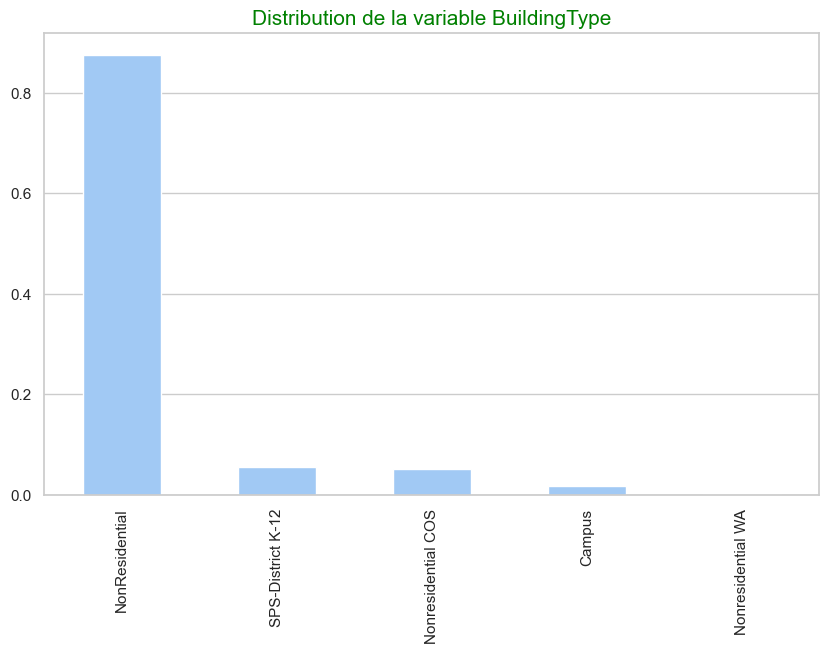

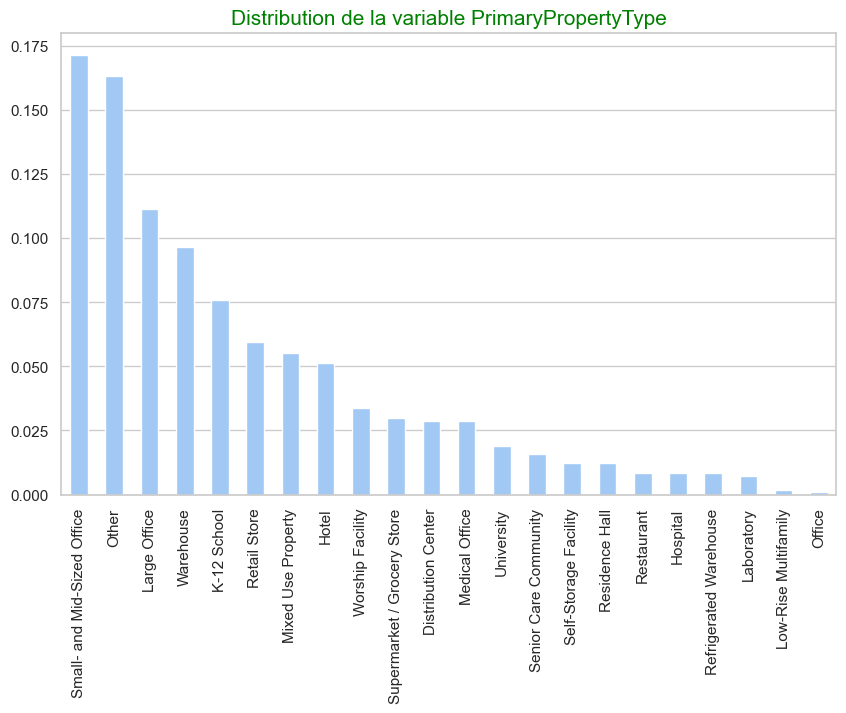

In [34]:
for v in variables_qualitatives:
    distribution_empirique_qualitatives(v)

**Conclusion : ces distributions sont assez peu équilibrées.**

La majeure partie des bâtiments est typée *NonResidential*.

Quant à l'usage principal, il s'agit de bureaux de petite et moyenne tailles.

Je remarque la présence d'une modalité *Low-Rise Multifamily* pour la variable *PrimaryPropertyType*.

Je dois supprimer ces observations typées **résidentielles**.

In [35]:
df = df.loc[df['PrimaryPropertyType'] != 'Low-Rise Multifamily']

### Analyse d'une sélection de variables quantitatives simples et significatives

In [36]:
variables_quantitatives = ['NumberofBuildings',
                           'NumberofFloors',
                           'PropertyGFATotal',
                           'SiteEnergyUseWN(kBtu)',
                           'TotalGHGEmissions',
                           'Age',
                           'ENERGYSTARScore']

J'utilise une fonction à appeler pour ces variables quantitatives.

Cette fonction fournit pour chaque variable :
- les mesures de tendance centrale :
    - la moyenne
    - la médiane
    - le mode
- les mesures de dispersion :
    - la variance empirique
    - l'écart-type empirique
- les mesures de forme :
    - le Skewness empirique
    - le Kurtosis empirique
- les représentations graphiques :
    - une distribution sous forme de diagramme de densité
    - une boîte à moustaches montrant les écarts interquartiles
    - une mesure de concentration avec la courbe de Lorenz et l'indice de Gini

In [37]:
def analyse_variable_quantitative(variable):
    print("-"*80)
    print('Analyse de la variable',variable)
    print("-"*5)
    print("Moyenne :",round(df[variable].mean(),2))
    print("Médiane :",round(df[variable].median(),2))
    print("Mode :",df[variable].mode())
    print("Variance :",round(df[variable].var(ddof=0),2))
    print("Ecart-type :",round(df[variable].std(ddof=0),2))
    print("Skewness :",round(df[variable].skew(),2))
    print("Kurtosis :",round(df[variable].kurtosis(),2))
    # Diagramme à densité
    plt.xlabel('Distribution de la variable '+str(variable), color='green', fontsize=15)
    plt.ylabel('Diagramme à densité', fontsize=13)
    sns.kdeplot(data=df, x=variable)
    plt.show()
    # Boxplot
    plt.xlabel(str(variable), color='green', fontsize=15)
    sns.boxplot(data=df, x=variable, showfliers=False, orient='h', showmeans=True, meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}, medianprops = {'color':"black"})
    plt.show()
    # Courbe de Lorenz
    n = len(df[variable])
    lorenz = np.cumsum(np.sort(df[variable])) / df[variable].sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    xaxis = np.linspace(0-1/n,1+1/n,len(lorenz)) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.title('Courbe de Lorenz pour la variable '+str(variable), color='green', fontsize=15)
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot([0,1], [0,1]) #tracer la bisséctrice
    plt.grid(visible=False)
    # Indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = round(2*S,2)
    plt.text(0.5, 0.4, 'Indice de Gini\n'+str(gini))
    plt.show()

J'utilise cette fonction sur les 2 targets.

--------------------------------------------------------------------------------
Analyse de la variable SiteEnergyUseWN(kBtu)
-----
Moyenne : 8738387.14
Médiane : 3353537.5
Mode : 0    0.0
Name: SiteEnergyUseWN(kBtu), dtype: float64
Variance : 433784891975729.1
Ecart-type : 20827503.26
Skewness : 8.93
Kurtosis : 104.25


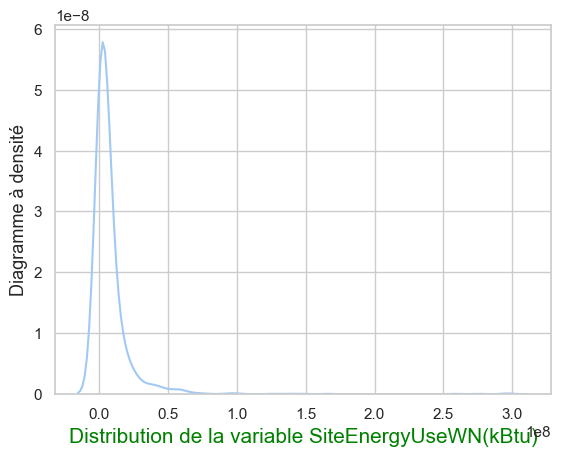

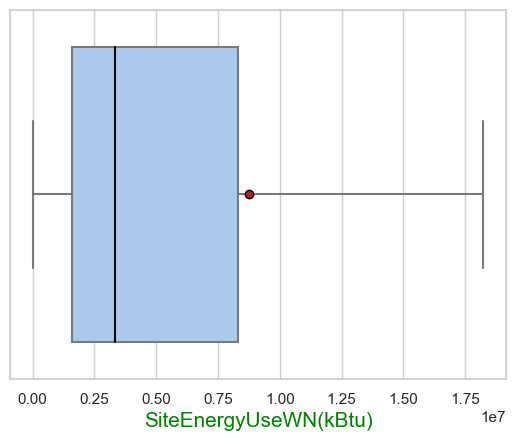

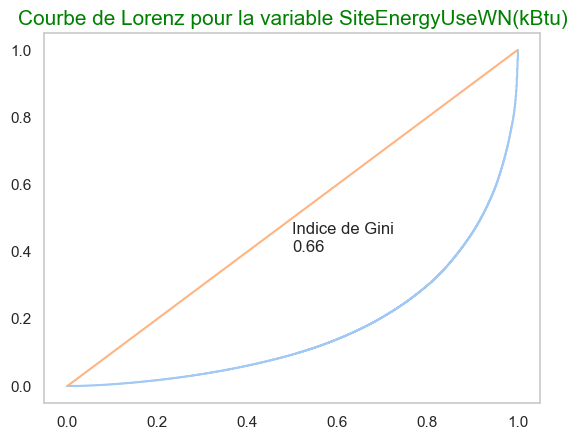

--------------------------------------------------------------------------------
Analyse de la variable TotalGHGEmissions
-----
Moyenne : 202.81
Médiane : 59.23
Mode : 0    0.0
Name: TotalGHGEmissions, dtype: float64
Variance : 520559.91
Ecart-type : 721.5
Skewness : 11.73
Kurtosis : 164.36


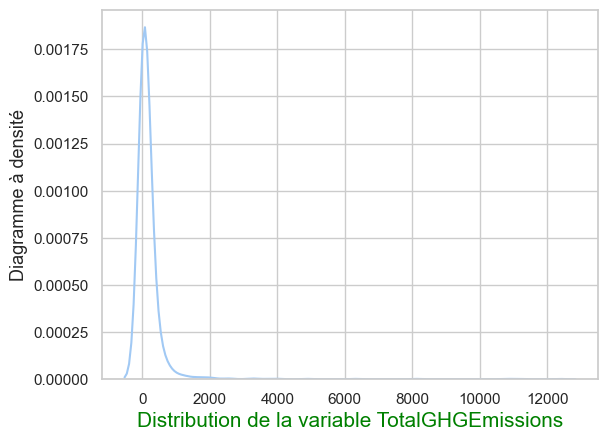

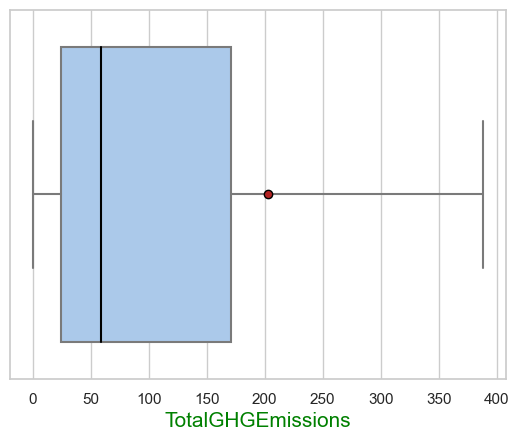

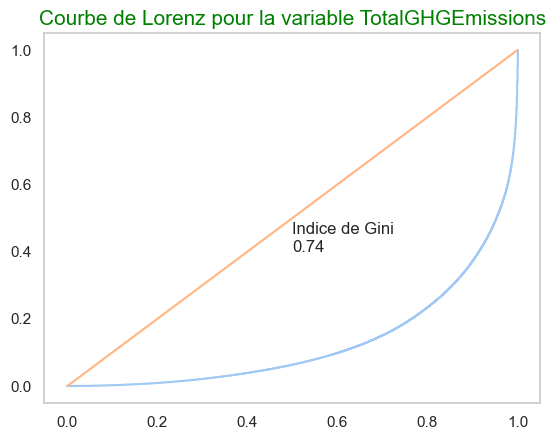

In [38]:
for v in ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']:
    analyse_variable_quantitative(v)

Les distributions sont plutôt concentrées et asymétriques avec une queue filant à droite.

## Analyses bivariées
### Recherche des corrélations linéaires entre paires de variables quantitatives intéressantes

Je commence par la matrice des corrélations.

In [39]:
corr = df[variables_quantitatives].corr()
corr

,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Age,ENERGYSTARScore
NumberofBuildings,1.000000,-0.031898,0.777680,0.108196,0.512294,0.039427,-0.063632
NumberofFloors,-0.031898,1.000000,0.371256,0.362420,0.158167,-0.069922,0.120616
PropertyGFATotal,0.777680,0.371256,1.000000,0.364637,0.612777,-0.073509,0.126192
SiteEnergyUseWN(kBtu),0.108196,0.362420,0.364637,1.000000,0.802021,-0.119694,-0.057933
TotalGHGEmissions,0.512294,0.158167,0.612777,0.802021,1.000000,-0.025781,-0.093729
Age,0.039427,-0.069922,-0.073509,-0.119694,-0.025781,1.000000,0.035770
ENERGYSTARScore,-0.063632,0.120616,0.126192,-0.057933,-0.093729,0.035770,1.000000


Ce n'est pas très lisible alors je simplifie avec une heatmap indiquant les coefficients de Pearson :

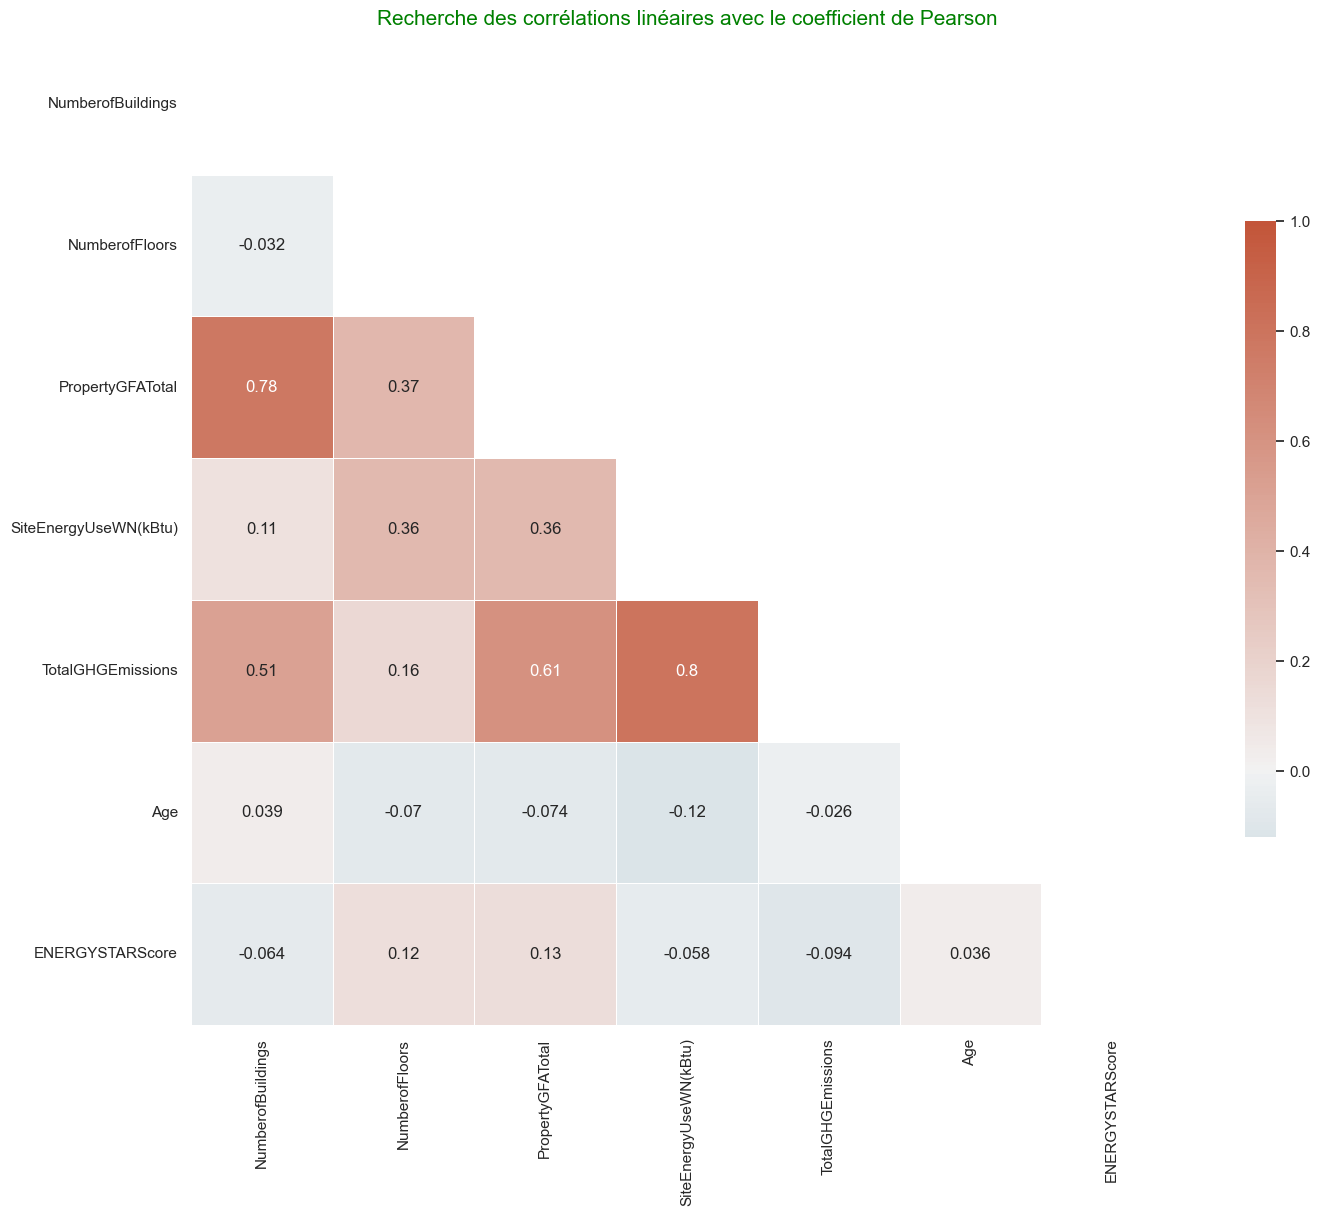

In [40]:
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.grid(visible=False)
plt.title('Recherche des corrélations linéaires avec le coefficient de Pearson', color='green', fontsize=15)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot = True, linewidths=.5, cbar_kws={"shrink": .5});

Les **2 variables target** semblent bien **corrélées** entre elles ce qui n'est pas gênant puisque je ne les modéliserai pas ensemble.

Il me faudra être attentif aux **corrélations entre les autres variables**.

Notamment, la surface totale de la propriété qui est très corrélée au nombre des bâtiments.

J'observe de plus près cette potentielle corrélation linéaire en utilisant une fonction afin de fournir pour une paire de variables :
- un diagramme de dispersion
- la droite de régression linéaire
- le coefficient de détermination R²

In [41]:
def regression_lineaire(variable1, variable2):
    # diagramme de dispersion
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x=variable1, y=variable2, hue='BuildingType')
    plt.ylabel(str(variable2))
    plt.xlabel(str(variable1))
    plt.grid()
    plt.legend(bbox_to_anchor=(1, 1.02))
    plt.title("Analyse de la régression linéaire entre\n"+str(variable2)+' et '+str(variable1), color='green', fontsize=15)
    # régression linéaire
    Y = df[[variable2]]
    X = df[[variable1]]
    X = X.copy() # On modifiera X, on en crée donc une copie
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
    a,b = result.params[variable1],result.params['intercept']
    plt.plot([df[variable1].min(),df[variable1].max()],[a*df[variable1].min()+b,a*df[variable1].max()+b], color='grey')
    # Calcul du coefficient de détermination
    r2 = round((st.pearsonr(df[variable1],df[variable2])[0])**2, 2)
    plt.text(df[variable1].max()*0.8, df[variable2].min()+(df[variable2].max()-df[variable2].min())/10, 'Coefficient de\ndétermination\n\nR² = '+str(r2), color='red')
    plt.show()

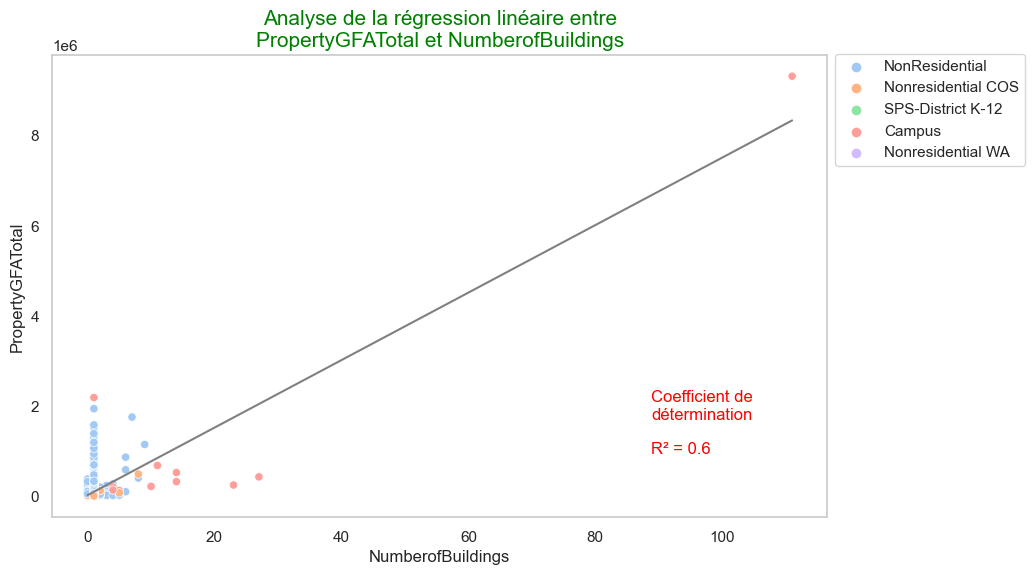

In [42]:
regression_lineaire('NumberofBuildings', 'PropertyGFATotal')

Il pourrait être admis une corrélation linéraire entre ces variables.

J'essaie de transformer la variable *NumberofBuildings* pour lever la corrélation.
La description indiquait que la valeur des 3 premiers quartiles est 1.
Quel est le ratio de propriétés avec plus d'un bâtiment ?

In [43]:
print("Taux de propriétés avec plus d'un bâtiment :",round(df.loc[df['NumberofBuildings'] > 1].shape[0] / df.shape[0] * 100,2), "%")

Taux de propriétés avec plus d'un bâtiment : 3.72 %


Comme il est relativement faible, je remplace la variable par une valeur binaire : 0 pour 1 seul bâtiment, 1 pour les autres.

In [44]:
df.loc[df['NumberofBuildings'] == 1, 'NumberofBuildings'] = 0
df.loc[df['NumberofBuildings'] > 1, 'NumberofBuildings'] = 1

Je vérifie la **disparition de la corrélation linéaire** :

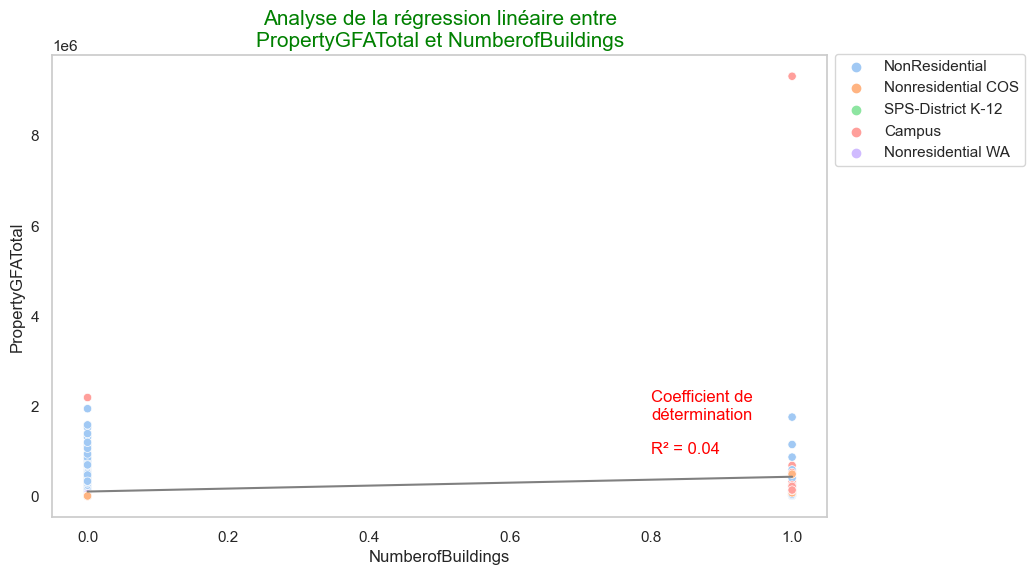

In [45]:
regression_lineaire('NumberofBuildings', 'PropertyGFATotal')

## Préparation des dataframes pour la modélisation

In [46]:
variables_consommation = ['SiteEnergyUseWN(kBtu)',
                          'BuildingType',
                          'PrimaryPropertyType',
                          'NumberofBuildings',
                          'NumberofFloors',
                          'PropertyGFATotal',
                          'Age',
                          'ENERGYSTARScore']
df_consommation = df[variables_consommation]
df_consommation.head(1)

,SiteEnergyUseWN(kBtu),BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,Age,ENERGYSTARScore
0,7456910.0,NonResidential,Hotel,0.0,12,88434,89,60.0


In [47]:
df_consommation.to_csv("df_consommation.csv", sep=',', index=False)

In [48]:
variables_emission = ['TotalGHGEmissions',
                      'BuildingType',
                      'PrimaryPropertyType',
                      'NumberofBuildings',
                      'NumberofFloors',
                      'PropertyGFATotal',
                      'Age',
                      'ENERGYSTARScore']
df_emission = df[variables_emission]
df_emission.head(1)

,TotalGHGEmissions,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,Age,ENERGYSTARScore
0,249.98,NonResidential,Hotel,0.0,12,88434,89,60.0


In [49]:
df_emission.to_csv("df_emission.csv", sep=',', index=False)